In [1]:
from utils import objective, objective_sem, read_from_json, results_to_csv
from utils_sevH import objective_sevH
import os
import sys
sys.path.append('..')
from data import ER, SW, ZACHARY
import matplotlib.pyplot as plt
import numpy as np
import itertools

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
if not os.path.exists('results'):
    os.mkdir('results')

# Common params

In [2]:
n_graphs = 64

N = 20
p_er = 0.2
g_params_er = {'type': ER, 'p': p_er}
g_params_sw = {'type': SW, 'k': 4, 'p': 0.5}
g_params_zachary = {'type': ZACHARY}
norm_S = False
norm_H = False
sort_h = False
neg_coefs = False
exp_coefs = True
pert_type = "rewire"
S_for_coefs = "binarized" # binarized, scaled, norm

p_n = 0.01
M = 50
K = 5
eps = 0.1

In [22]:
EXPS = [
    {
        "func": "estH_unpertS",
        "cy": "non-st", # not used, so not important
        "legend": "FI",
        "fmt": "o-"
    },
    {
        "func": "estH_iter",
        "cy": "non-st",
        "legend": "ITER-NONST",
        "fmt": "P-"
    },
    {
        "func": "estH_iter_rew",
        "cy": "non-st",
        "legend": "ITER-REW-NONST",
        "fmt": "p-"
    },
    {
        "func": "estH_iter_rew",
        "cy": "samp",
        "legend": "ITER-REW-ST-SAMP",
        "fmt": "v-"
    }
]

In [23]:
args = {
    'non-st': {
        'estH_denS': [0.001, 1.], #[gamma, delta],
        'estH_iter': [0.03, 0.005, 0., 3.5], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.1, 0.08, 0., 5e-4, 1.], #[lambd, gamma, delta, beta, inc_gamma]
        'estH_tls_sem': [0.07, 0.4],#[0.5, 0.75][0.1, 0.01]
        'estH_llsscp': [1.] #[rho]
    },
    'real': {
        'estH_denS': [0.2, 10.], #[gamma, delta],
        'estH_iter': [5e-4, 1e-4, 10., 1.], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 1, 0.1, 0.01, 1.1],#[0.01, 0.2, 1., 0.01, 2.] #[lambd, gamma, delta, beta, inc_gamma] [1, 1, 0.1, 0.01, 1.1]#
        'estH_tls_sem': [0.07, 0.4]#[0.5, 0.75][0.1, 0.01]
    }, 
    'samp': {
        'estH_denS': [0.005, 0.1], #[gamma, delta_samp],
        'estH_iter': [0.4, 0.008, 0.0005, 3.], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.2, 0.1, 0.001, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }
}

In [24]:
args_coefs = {
    'non-st': {
        'estH_iter': [0.02, 0.001, 0., 1.5], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.01, 0.01, 0., 5e-4, 1.5], #[lambd, gamma, delta, beta, inc_gamma]
    },
    'samp': {
        'estH_iter': [0.4, 0.008, 0.0005, 3.], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.005, 0.002, 0.005, 0.0001, 1.5] #[lambd, gamma, delta, beta, inc_gamma]
    }
}

# I - Filter order

In [25]:
Ks = [2, 3, 4, 5, 6]
Ks = [3, 4, 5, 6, 7]
results_1 = {}
print("Starting K:", end="")
for k in Ks:
    print(f" {k}", end="", flush=True)
    results_1[k] = objective(p_n, 20, k, 0.2, EXPS, args_coefs, n_graphs, N, g_params_er)
print(" - DONE")

Starting K: 3

KeyError: 'real'

Text(0, 0.5, 'Median error in H coefficients')

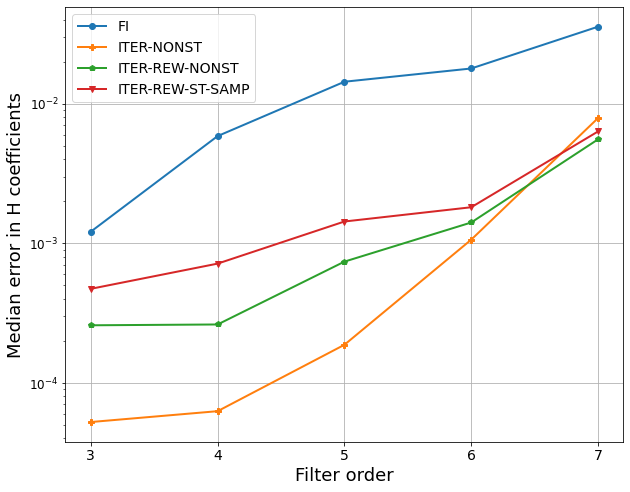

In [ ]:
plt.figure(figsize=(10,8))
for i, exp in enumerate(EXPS):
    plt.semilogy(Ks, [results_1[k]['med_H_coefs'][i] for k in Ks], exp['fmt'], linewidth=2)
plt.legend([exp["legend"] for exp in EXPS], fontsize=14)
plt.xticks(Ks, Ks, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Filter order", fontsize=18)
plt.ylabel("Median error in H coefficients", fontsize=18)
#plt.savefig("images/1-FilterOrder.png", format='png')
#plt.savefig("images/1-FilterOrder.eps", format='eps')

In [8]:
results_to_csv(results_1, "Filter Order", [exp['legend'] for exp in EXPS], "med_H_coefs", "results/1-FilterOrder.csv")

# II - Modifying graph and perturbation

In [9]:
EXPS = [
    {
        "func": "estH_iter",
        "cy": "non-st",
        "legend": "ITER-NONST",
        "fmt": "P-"
    },
]

In [10]:
g_types = [ER, SW]
perts = ["creat", "dest", "creat-dest", "selective"]
eps_vals = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
results_2 = {}
results_3 = {}
print("Starting G params and perturbation:", end="")
for e in eps_vals:
    print(f" {e}", end="", flush=True)
    err_H = []
    err_S = []
    for g_type, pert in itertools.product(g_types, perts):
        if g_type == SW:
            g_params = g_params_sw
        else:
            g_params = g_params_er
        if pert == "selective":
            results_dict = objective(p_n, M, K, e, EXPS, args, n_graphs, N, g_params, pert_type="creat-dest", sel_ratio=4, sel_node_idx=5)
        else:
            results_dict = objective(p_n, M, K, e, EXPS, args, n_graphs, N, g_params, pert_type=pert)
        err_H.append(results_dict['med_H'].item())
        err_S.append(results_dict['med_S'].item())
    results_2[e] = np.array(err_H)
    results_3[e] = np.array(err_S)
print(" - DONE")

Starting G params and perturbation: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 - DONE


Text(0, 0.5, 'H Median error')

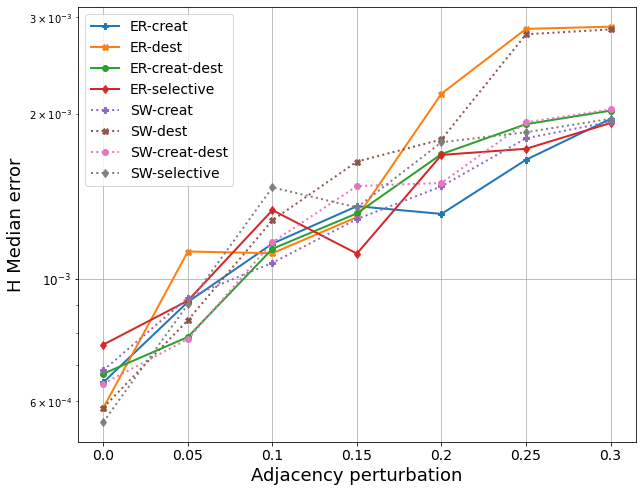

In [11]:
plt.figure(figsize=(10,8))
fmts = {"creat": "P", "dest": "X", "creat-dest": "o", "selective": "d"}
for i, (g_type, pert) in enumerate(itertools.product(g_types, perts)):
    plt.semilogy(eps_vals, [results_2[e][i] for e in eps_vals], f"{fmts[pert]}{'-' if g_type == ER else ':'}", linewidth=2, label=f"{'ER' if g_type == ER else 'SW'}-{pert}")
plt.legend(fontsize=14)
plt.xticks(eps_vals, eps_vals, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Adjacency perturbation", fontsize=18)
plt.ylabel("H Median error", fontsize=18)
#plt.savefig("images/2-GraphAndPert-H.png", format='png')
#plt.savefig("images/2-GraphAndPert-H.eps", format='eps')
#plt.ylim(1e-4, 1)

In [12]:
col_names = []
for i, (g_type, pert) in enumerate(itertools.product(g_types, perts)):
    col_names.append(f"{'ER' if g_type == ER else 'SW'}-{pert}")
results_to_csv(results_2, "Adjacency perturbation", col_names, "", "results/2-GraphAndPert-H.csv")

Text(0, 0.5, 'S Median error')

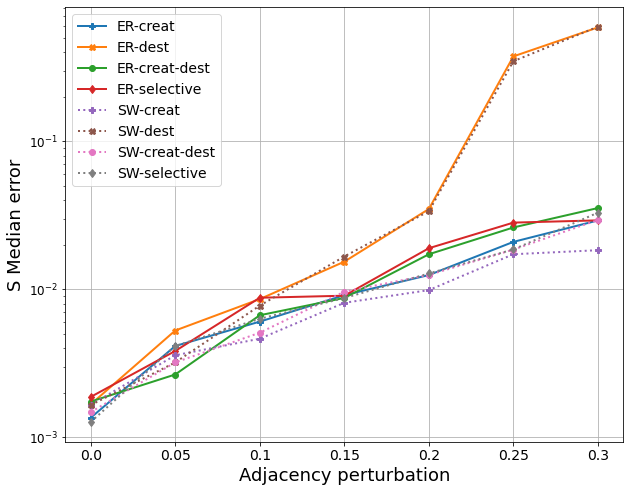

In [13]:
plt.figure(figsize=(10,8))
for i, (g_type, pert) in enumerate(itertools.product(g_types, perts)):
    plt.semilogy(eps_vals, [results_3[e][i] for e in eps_vals], f"{fmts[pert]}{'-' if g_type == ER else ':'}", linewidth=2, label=f"{'ER' if g_type == ER else 'SW'}-{pert}")
plt.legend(fontsize=14)
plt.xticks(eps_vals, eps_vals, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Adjacency perturbation", fontsize=18)
plt.ylabel("S Median error", fontsize=18)
#plt.savefig("images/3-GraphAndPert-S.png", format='png')
#plt.savefig("images/3-GraphAndPert-S.eps", format='eps')

In [14]:
results_to_csv(results_3, "Adjacency perturbation", col_names, "", "results/3-GraphAndPert-S.csv")

# IV - Comparison with TLS-SEM

In [15]:
EXPS = [
    {
        "func": "estH_tls_sem",
        "cy": "real",
        "legend": "TLS-SEM",
        "fmt": "P"
    },
    {
        "func": "estH_iter",
        "cy": "real",
        "legend": "RFI-iter",
        "fmt": "o"
    },
    {
        "func": "estH_llsscp",
        "cy": "non-st",
        "legend": "LLS-SCP (Natali)",
        "fmt": "s"
    }
]

In [16]:
eps_vals = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
results_4 = {}
print("Starting comparison with TLS-SEM:", end="")
for e in eps_vals:
    print(f" {e}", end="", flush=True)
    results_4[e] = objective_sem(p_n, M, K, e, EXPS, args, n_graphs, N, g_params_er)  
print(" - DONE")

Starting comparison with TLS-SEM: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 - DONE


Text(0, 0.5, 'H Median error')

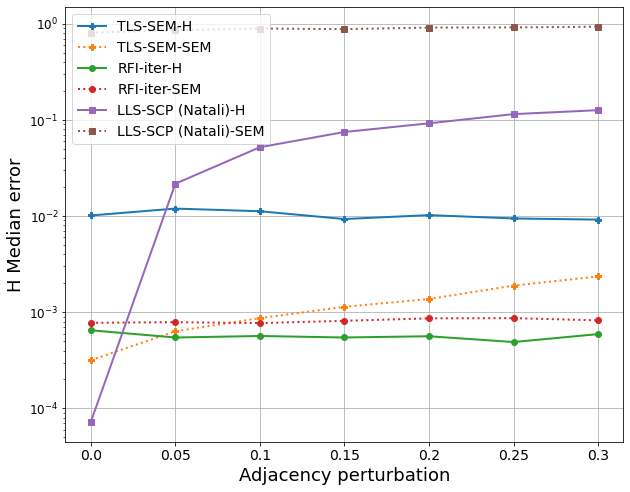

In [17]:
plt.figure(figsize=(10,8))
for j, exp in enumerate(EXPS):
    plt.semilogy(eps_vals, [results_4[e]['med_H'][0,j] for e in eps_vals], f"{exp['fmt']}-", linewidth=2, label=f"{exp['legend']}-H")
    plt.semilogy(eps_vals, [results_4[e]['med_H'][1,j] for e in eps_vals], f"{exp['fmt']}:", linewidth=2, label=f"{exp['legend']}-SEM")
plt.legend(fontsize=14)
plt.xticks(eps_vals, eps_vals, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Adjacency perturbation", fontsize=18)
plt.ylabel("H Median error", fontsize=18)
#plt.savefig("images/4-ComparisonTLS-LLS.png", format='png')
#plt.savefig("images/4-ComparisonTLS-LLS.eps", format='eps')

In [18]:
#results_to_csv(results_4, "Adjacency perturbation", [exp['legend'] for exp in EXPS], "med_H", "results/4-ComparisonTLS-LLS.csv")

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
plt.figure(figsize=(10,8))
for j, exp in enumerate(EXPS):
    plt.semilogy(eps_vals, [results_4[e]['med_S'][0,j] for e in eps_vals], f"{exp['fmt']}-", linewidth=2, label=f"{exp['legend']}-H")
    plt.semilogy(eps_vals, [results_4[e]['med_S'][1,j] for e in eps_vals], f"{exp['fmt']}:", linewidth=2, label=f"{exp['legend']}-SEM")
plt.legend(fontsize=14)
plt.xticks(eps_vals, eps_vals, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Adjacency perturbation", fontsize=18)
plt.ylabel("S Median error", fontsize=18)

# V - RFI vs Joint-RFI

In [ ]:
exps = read_from_json('exps/exps_5_sevH_T.json')

In [ ]:
args_sevH = {
    'non-st': {
        'estH_denS': [0.001, 1.], #[gamma, delta],
        'estH_iter': [3e-2, 5e-3, 0., 4.],#[1e-4, 2, 0., 1.5], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.1, 0.08, 0., 5e-4, 1.],#[1e-3, 5, 0., 1e-2, 3.],#[0.1, 0.1, 0., 0.0001, 1.1], #[lambd, gamma, delta, beta, inc_gamma]
        'estH_tls_sem': [0.07, 0.38],#[0.5, 0.75]#[0.07, 0.4][0.1, 0.01]
        'estHs_denS': [1, 0.1], #[gamma, delta],
        'estHs_iter': [0.4, 1e-3, 0., 1.5],#[0.03, 0.005, 0., 4.], #[lambd, gamma, delta, inc_gamma],
        'estHs_iter_rew': [0.02, 1e-4, 0., 5e-4, 2.] #[lambd, gamma, delta, beta, inc_gamma]
    },
    'real': {
        'estH_denS': [0.2, 10.], #[gamma, delta],
        'estH_iter': [5e-4, 1e-4, 10., 1.], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 1, 0.1, 0.01, 1.1],#[0.01, 0.2, 1., 0.01, 2.] #[lambd, gamma, delta, beta, inc_gamma] [1, 1, 0.1, 0.01, 1.1]#
        'estHs_denS': [1, 0.1], #[gamma, delta],
        'estHs_iter': [0.1, 0.1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estHs_iter_rew': [0.1, 0.1, 1, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }, 
    'samp': {
        'estH_denS': [0.005, 0.1], #[gamma, delta_samp],
        'estH_iter': [0.01, 2e-3, 2e-3, 1.3], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1e-3, 5, 0.001, 1e-2, 3.], #[lambd, gamma, delta, beta, inc_gamma]
        'estHs_denS': [1, 0.1], #[gamma, delta],
        'estHs_iter': [0.2, 1e-3, 0.02, 1.6], #[lambd, gamma, delta, inc_gamma],
        'estHs_iter_rew': [0.07, 1e-3, 0.1, 5e-4, 3.]#[0.1, 0.1, 1, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }
}

In [ ]:
Ts = [1, 3, 5]
Ts = [1,2,3,4,5]
results_5 = {}
print("Starting T:", end="")
for t in Ts:
    print(f" {t}", end="", flush=True)
    results_5[t] = objective_sevH(0.01, 15, K, 0.3, t, exps, args_sevH, n_graphs, N, g_params_sw)#_er) #n_graphs
print(" - DONE")

In [ ]:
plt.figure(figsize=(10,8))
for i, exp in enumerate(exps):
    plt.semilogy(Ts, [results_5[t]['med_H'][i] for t in Ts], f"{exp['fmt']}{'-' if exp['joint'] else ':'}", linewidth=2)
plt.legend([exp["legend"] for exp in exps], fontsize=14)
plt.xticks(Ts, Ts, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Number of filters", fontsize=18)
plt.ylabel("H Median error", fontsize=18)
#plt.savefig("images/5-Joint-RFI.png", format='png')
#plt.savefig("images/5-Joint-RFI.eps", format='eps')

In [ ]:
results_to_csv(results_5, "Number of filters", [exp['legend'] for exp in EXPS], "med_H", "results/5-Joint-RFI.csv")

In [ ]:
plt.figure(figsize=(10,8))
for i, exp in enumerate(exps):
    plt.semilogy(Ts, [results_5[t]['med_S'][i] for t in Ts], f"{exp['fmt']}{'-' if exp['joint'] else ':'}", linewidth=2)
plt.legend([exp["legend"] for exp in exps], fontsize=14)
plt.xticks(Ts, Ts, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Number of filters", fontsize=18)
plt.ylabel("S Median error", fontsize=18)

# VI and VII - Evolution of error with number of samples

In [ ]:
exps = read_from_json('exps/exps_6_samp_exp.json')

In [ ]:
Ms = [15, 40, 100, 300]#, 500]
results_6 = {}
print("Starting M:", end="")
for m in Ms:
    print(f" {m}", end="", flush=True)
    results_6[m] = objective_sevH(0.03, m, K, 0.4, 3, exps, args_sevH, n_graphs, N, g_params_zachary) #n_graphs
print(" - DONE")

In [ ]:
plt.figure(figsize=(10,8))
for i, exp in enumerate(exps):
    plt.semilogy(Ms, [results_6[m]['med_H'][i] for m in Ms], f"{exp['fmt']}{'-' if exp['joint'] else ':'}", linewidth=2)
plt.legend([exp["legend"] for exp in exps], fontsize=14)
plt.xticks(Ms, Ms, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Number of samples", fontsize=18)
plt.ylabel("H Median error", fontsize=18)
#plt.savefig("images/6-SamplesExperiment-H.png", format='png')
#plt.savefig("images/6-SamplesExperiment-H.eps", format='eps')

In [ ]:
results_to_csv(results_6, "Number of samples", [exp['legend'] for exp in EXPS], "med_H", "results/6-SamplesExperiment-H.csv")

In [ ]:
plt.figure(figsize=(10,8))
for i, exp in enumerate(exps):
    plt.semilogy(Ms, [results_6[m]['med_S'][i] for m in Ms], f"{exp['fmt']}{'-' if exp['joint'] else ':'}", linewidth=2)
plt.legend([exp["legend"] for exp in exps], fontsize=14)
plt.xticks(Ms, Ms, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Number of samples", fontsize=18)
plt.ylabel("S Median error", fontsize=18)
#plt.savefig("images/7-SamplesExperiment-S.png", format='png')
#plt.savefig("images/7-SamplesExperiment-S.eps", format='eps')

In [ ]:
results_to_csv(results_6, "Number of samples", [exp['legend'] for exp in EXPS], "med_S", "results/7-SamplesExperiment-S.csv")

# Tests

In [ ]:
exps_aux = [
    {
        "func": "estH_iter",
        "cy": "non-st",
        "legend": "ITER",
        "fmt": "P",
        "joint": False
    }
]

In [ ]:
args_old = {
    'non-st': {
        'estH_denS': [0.001, 1.], #[gamma, delta],
        'estH_iter': [0.1, 0.1, 0., 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.1, 0.1, 0., 0.0001, 1.1], #[lambd, gamma, delta, beta, inc_gamma]
        'estH_tls_sem': [0.07, 0.38],#[0.5, 0.75]#[0.07, 0.4][0.1, 0.01]
        'estHs_denS': [1, 0.1], #[gamma, delta],
        'estHs_iter': [0.1, 0.1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estHs_iter_rew': [0.1, 0.1, 1, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }
}
args_new = {
    'non-st': {
        'estH_denS': [0.001, 1.], #[gamma, delta],
        'estH_iter': [0.03, 0.005, 0., 4.], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [0.1, 0.08, 0., 5e-4, 1.], #[lambd, gamma, delta, beta, inc_gamma]
        'estH_tls_sem': [0.07, 0.4],#[0.5, 0.75][0.1, 0.01]
        'estHs_denS': [1, 0.1], #[gamma, delta],
        'estHs_iter': [0.03, 0.005, 0., 4.], #[lambd, gamma, delta, inc_gamma],
        'estHs_iter_rew': [0.1, 0.1, 1, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }
}

In [ ]:
g_types = [ER, SW]
perts = ["creat-dest"]
eps_vals = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
results_2 = {}
results_3 = {}
print("Starting G params and perturbation:", end="")
for e in eps_vals:
    print(f" {e}", end="", flush=True)
    err_H = []
    err_S = []
    for g_type, pert in itertools.product(g_types, perts):
        if g_type == SW:
            g_params = g_params_sw
        else:
            g_params = g_params_er
        results_dict = objective(p_n, M, K, e, exps_aux, args_old, n_graphs, N, g_params, pert_type=pert)
        err_H.append(results_dict['med_H'].item())
        err_S.append(results_dict['med_S'].item())
    results_2[e] = np.array(err_H)
    results_3[e] = np.array(err_S)
print("DONE")

In [ ]:
plt.figure(figsize=(10,8))
fmts = {"creat": "P", "dest": "X", "creat-dest": "o"}
for i, (g_type, pert) in enumerate(itertools.product(g_types, perts)):
    plt.plot(eps_vals, [results_2[e][i] for e in eps_vals], f"{fmts[pert]}-", linewidth=2, label=f"{'ER' if g_type == ER else 'SW'}-{pert}")
plt.legend(fontsize=14)
plt.xticks(eps_vals, eps_vals, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Adjacency perturbation", fontsize=18)
plt.ylabel("H Median error", fontsize=18)

In [ ]:
g_types = [ER, SW]
perts = ["creat-dest"]
eps_vals = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
results_22 = {}
results_3 = {}
print("Starting G params and perturbation:", end="")
for e in eps_vals:
    print(f" {e}", end="", flush=True)
    err_H = []
    err_S = []
    for g_type, pert in itertools.product(g_types, perts):
        if g_type == SW:
            g_params = g_params_sw
        else:
            g_params = g_params_er
        results_dict = objective(p_n, M, K, e, exps_aux, args_new, n_graphs, N, g_params, pert_type=pert)
        err_H.append(results_dict['med_H'].item())
        err_S.append(results_dict['med_S'].item())
    results_22[e] = np.array(err_H)
    results_3[e] = np.array(err_S)
print("DONE")

In [ ]:
plt.figure(figsize=(10,8))
fmts = {"creat": "P", "dest": "X", "creat-dest": "o"}
for i, (g_type, pert) in enumerate(itertools.product(g_types, perts)):
    plt.plot(eps_vals, [results_2[e][i] for e in eps_vals], f"{fmts[pert]}-", linewidth=2, label=f"OLD-{'ER' if g_type == ER else 'SW'}-{pert}")
    plt.plot(eps_vals, [results_22[e][i] for e in eps_vals], f"{fmts[pert]}-", linewidth=2, label=f"NNI-{'ER' if g_type == ER else 'SW'}-{pert}")
plt.legend(fontsize=14)
plt.xticks(eps_vals, eps_vals, fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.xlabel("Adjacency perturbation", fontsize=18)
plt.ylabel("H Median error", fontsize=18)

In [ ]:
import data
import opt

In [ ]:
X, Y_poly, Y_sem, Cy_poly, Cy_sem, Cy_samp_poly, Cy_samp_sem, H_poly, H_sem, S, Sn, h = data.gen_data_SEM(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert)

In [ ]:
S_tilde = np.eye(N) - S
H_est = np.linalg.inv(S_tilde)
norm_H_sem = (H_sem**2).sum()
norm_H_poly = (H_poly**2).sum()

In [ ]:
((H_sem - H_est)**2).sum()/norm_H_sem, ((H_poly - H_est)**2).sum()/norm_H_poly

In [ ]:
_, H_est_2, S_est_2 = opt.estH_tls_sem(X, Y_sem, Sn, Cy_samp_sem, [0.07, 0.4], H_true = H_sem, S_true=S)
_, H_est_3, S_est_3 = opt.estH_tls_sem(X, Y_poly, Sn, Cy_samp_poly, [0.07, 0.4], H_true = H_poly, S_true=S)

In [ ]:
((H_sem - H_est_2)**2).sum()/norm_H_sem, ((H_poly - H_est_2)**2).sum()/norm_H_poly

In [ ]:
((H_sem - H_est_3)**2).sum()/norm_H_sem, ((H_poly - H_est_3)**2).sum()/norm_H_poly

# Tests Joint

In [ ]:
exps_joint = [
    {
        "func": "estH_iter",
        "cy": "non-st",
        "legend": "ITER",
        "fmt": "P",
        "joint": False
    },
    {
        "func": "estHs_iter",
        "cy": "non-st",
        "legend": "ITER-J",
        "fmt": "P",
        "joint": True
    },
]

In [ ]:
Ts = [1, 3, 5, 6]
Ts = [1]
results_5 = {}
print("Starting T:", end="")
for t in Ts:
    print(f" {t}", end="", flush=True)
    results_5[t] = objective_sevH(p_n, M, K, eps, t, exps_joint, args_new, 1, N, g_params_er) #n_graphs
print(" - DONE")

In [ ]:
results_5

In [ ]:
import data
import sev_filters_opt
import opt

In [ ]:
print(f"{N=}, {M=}, T=5, {g_params_er=}, {p_n=}, {eps=}, {K=}, {neg_coefs=}, {exp_coefs=}, {sort_h=}, {norm_S=}, {norm_H=}, {pert_type=}")

In [ ]:
X, Y, Cy, Cy_samp, Hs, S, Sn, h = data.gen_data_sev_H(N, M, 5, g_params_er, p_n, 0.2, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

In [ ]:
H_sev = sev_filters_opt.filter_id(Y, X, Sn, 0.01, 0, Cy)
H_sing = opt.filter_id(Y[0,:,:], X[0,:,:], Sn, 0.01, 0, Cy[0,:,:])

In [ ]:
np.allclose(H_sev.squeeze(), H_sing)

In [ ]:
S_sev = sev_filters_opt.graph_id_rew(Sn, H_sev, Cy, np.ones((N,N)), np.ones((N,N)), 0.1, 0.01, 0., 0.0001)
S_sing = opt.graph_id_rew(Sn, H_sing, Cy[0,:,:], np.ones((N,N)), np.ones((N,N)), 0.1, 0.01, 0., 0.0001)

In [ ]:
np.allclose(S_sev, S_sing)

In [ ]:
_, Hs_sev, S_sev = sev_filters_opt.estHs_iter(X, Y, Sn, Cy, [3., 1e-3, 0., 4.], Hs_true=Hs, S_true=S)

In [ ]:
norm_h = np.sqrt((Hs**2).sum((1,2)))
np.median(((Hs - Hs_sev)**2).sum((1,2)) / norm_h)

# Tests Joint 2

In [ ]:
import data
import sev_filters_opt
import opt

In [ ]:
exps_joint = [
    {
        "func": "estH_iter",
        "cy": "non-st",
        "legend": "ITER-J",
        "fmt": "P",
        "joint": False
    },
    {
        "func": "estHs_iter",
        "cy": "non-st",
        "legend": "ITER-J",
        "fmt": "P",
        "joint": True
    }
]

In [ ]:
args_joint = {
    'non-st': {
        'estH_iter': [0.03, 0.005, 0., 4.],
        'estHs_iter': [3.1421390841754704, 0.001800929244830857, 0., 4.067171516543095]#[3., 0.005, 0., 4.]#[3., 1e-3, 0., 4.]
    }
}

In [ ]:
X, Y, Cy, Cy_samp, Hs, S, Sn, h = data.gen_data_sev_H(N, M, 5, g_params_er, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

In [ ]:
objective_sevH(p_n, M, K, eps, 5, exps_joint, args_joint, 64, N, g_params_er)